# Nonlinear Regression Case Study: Adsorptive Nanoporous Membranes

&copy; Elvis A. Eugene and Alexander W. Dowling, University of Notre Dame

CBE20258, Spring 2020

## Background

Prof. William Phillip has been developing novel adsorptive nanoporous membranes to remove heavy metals from water. He has asked for your help designing a water treatment system. Specifically, **given laboratory data for these membrane systems, how much Pb (lead) can be removed per batch?**

As seniors, you will learn about **adsorption-based systems in Separation Processes**. For this project, you only need to know some basics: adsorptive systems preferentially adsorb a contaminant from a bulk fluid, similar to how dust sticks to a Swiffer cleaning cloth. The amount of contaminant, Pb in this project, that adsorbs (i.e. sticks) to the water treatment membranes can be modeled with the **Langmuir isotherm**:

$$q = \frac{Q \cdot K \cdot c}{1 + K \cdot c}$$

where $c$ is the concentration of contaminant in the bulk fluid (water), $q$ is the loading of contaminant on the sorbent (membrane), $K$ is the binding affinity and $Q$ is the capacity.

Prof. Phillip's lab has provided us with the following data:

| Contaminant Concentration in Bulk (mM) | Contaminant Loading on Sorbent (mmol/g) |
| ------ | ------ |
| 1 | 0.5 |
| 2.5 | 0.9 |
| 5 | 1 |
| 10 | 1.33 |
| 20 | 1.3 |
| 40 | 1.4 |


In this case study, you will analyze these data as consultants for Prof. Phillip:
1. Fit a Langmuir isotherm (i.e., determine $K$ and $Q$) using provided, real data ($c$ and $q$).
2. Integrate a differential equation model to calculate the batch time.
3. Estimate the uncertainty in the fitted parameters and propagate this uncertainty through the systems model.

Moreover, we will compare three different regression strategies for Step 1; we will then see how our choices propogate through Steps 2 and 3.

This comprehensive case study combines several key concepts from all three pillars of this class: Python, numerical methods, and data analytics. The **final project** will follow a similar structure. Much of the Python code can be adapted from previous homework assignments and class activities.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Determine the units of $K$ and $Q$. Hint: $1$ in the denominator of the Langmuir isotherm is dimensionless.
</div>

In [1]:
# load libraries
import numpy as np
from scipy import optimize, stats, integrate
import matplotlib.pyplot as plt
import pandas as pd

# define the data
c = np.array([1, 2.5, 5, 10, 20, 40]);
q = np.array([0.5, 0.9, 1.0, 1.33, 1.3, 1.4]);

# number of observations
n = len(c);

# number of fitted parameters
p = 2;

## 1. Regression Analysis

We will now compare three different regression strategies for the Langmuir isotherm problem:
1. Linear Regresssion after Transformation
2. Linear Regression after a Different Transformation
3. Nonlinear Regression

For each strategy, we will follow the same basic steps:
* Set up the problem, including deriving the transformation (if applicable)
* Perform the regression calculation
* Plot the experimental data (with transformed variables if applicable)
* Plot the experimental data versus fitted model ($q$ vs $c$)
* Graphically inspect the residuals
* Compute the covariance matrix for the fitted parameters, transform to the original parameters (if applicable)



### A. Paramter estimation using a transformation and linear regression

#### Step i: Setup and Best Fit

We will start our analysis by performing a transformation; this is neccessary to apply linear regression. We start with the Languir isotherm:

$$ q = \frac{Q \cdot K \cdot c}{1 + K \cdot c}$$

With a little bit of algebra, we obtain:

$$ \frac{c}{q} =  \frac{c}{Q} + \frac{1}{Q \cdot K} $$

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Write down the mathematical steps to go from the original isotherm $q=~...$ to the transformed isotherm $c/q =~...~$.
</div>

You may be asking yourselves, *how is that model linear*?!? We just need to define our variables and parameters carefully:

$$ \underbrace{\frac{c}{q}}_{y} =  \underbrace{\frac{1}{Q}}_{\beta_1} \cdot \underbrace{c}_{x} + \underbrace{\frac{1}{K \cdot Q}}_{\beta_0}   $$

Recall $x$ is the independent variable, $y$ is the observed variable, $\beta_0$ is the intercept, and $\beta_1$ is the slope. With this transformation, we can compute the regression coefficients:

In [2]:
# Code for parameter estimation using linear regression
x = c;
y = c/q;

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope =",slope)
print("intercept =",intercept)
print("R-squared:",r_value**2)



slope = 0.6861090472380716
intercept = 1.23217641968572
R-squared: 0.9987035006310445


Alright, we now have estimates for $\beta_0$ and $\beta_1$. But we really care about $K$ and $Q$. Let's reverse the transformation.

$$Q = \frac{1}{\beta_1}, \qquad  K = \frac{\beta_1}{\beta_0}$$

In [3]:
## Reverse transformation to obtain Q and K and display results
Qlin1 = 1/slope;
Klin1 = slope/intercept;
print("\nK (linear regression) = {0:0.1f} l/mmol".format(Klin1));
print("Q (linear regression) = {0:0.1f} mmol/g_membrane".format(Qlin1));


K (linear regression) = 0.6 l/mmol
Q (linear regression) = 1.5 mmol/g_membrane



#### Step ii: Setup Best Fit Plot for Best Fit Model and Residuals

Now we want to visualize the quality of the fit. Because we plan to repeat the regression analysis two more times, we invested in writing functions for the visualization. This means we just need to declare the plotting procedures once and we can reuse them. This is a good programming practice; use functions to maximize code reuse.

We'll start by defining the first function which **plots the linearized isotherm** and **plots the transformed residuals**.

In [7]:
# define a function to plot linearized isotherm 
def plot_liniso(x,y,slope,intercept,title):
    ''' 
    function to plot the linearized model and residuals
    Arguments:
        x: transformed independent variable (float vector)
        y: transformed independent variable (float vector)
        slope: fitted parameter 1 (float)
        intercept: fitted parameter 2 (float)
        title: keyword in plot title (string). Either 'lin1' or 'lin2'
        
    Returns:
        nothing
    '''
    
    assert (title is 'lin1') or (title is 'lin2'), "Argument title must be 'lin1' or 'lin2'"
    
    ## evaluate the best fit line
    # determine the max value of x
    xmax = np.amax(x);
    # define range of x to evaluate the model
    x_span = np.linspace(0,1.2*xmax,50);
    # evaluate the model
    y_hat = slope*x_span + intercept
    
    ## plot the best fit line
    plt.figure()
    plt.plot(x,y,'ro',label = 'data');
    plt.plot(x_span, y_hat, 'k', label='best fit')
    
    if (title == 'lin1'):
        plt.xlabel("c (mM)")
        plt.ylabel("c/q (grams membrane / L)")
    elif (title == 'lin2'):
        plt.xlabel("1/c (l/mmol)")
        plt.ylabel("1/q (grams membrane / mmol)")            
            
    plt.grid(True)
    plt.title('Transformed Linear Langmuir Isotherm')
    plt.legend()
    plt.show()
    
    
    ## calculate the residuals
    r = y - (x*slope + intercept);
    
    ## plot the residuals versus concentration
    plt.figure()
    plt.plot(c,r,'ro')
    
    if (title == 'lin1'):
        plt.ylabel('Residual (grams membrane / L)')
    elif (title == 'lin2'):
        plt.ylabel('Residual (grams membrane / mmol)')
                      
    plt.xlabel('Equilibrium concentration (mM)')
    plt.grid(True)
    plt.title('Transformed Residuals')
    plt.show()
    
# End: define a function to linearized isotherm 

<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\ebrea\AppData\Local\Temp\ipykernel_25644\1538165633.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert (title is 'lin1') or (title is 'lin2'), "Argument title must be 'lin1' or 'lin2'"
C:\Users\ebrea\AppData\Local\Temp\ipykernel_25644\1538165633.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert (title is 'lin1') or (title is 'lin2'), "Argument title must be 'lin1' or 'lin2'"


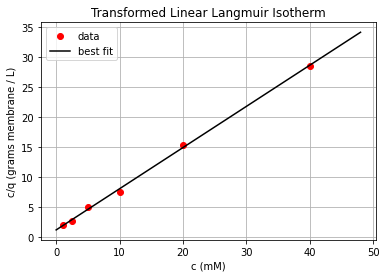

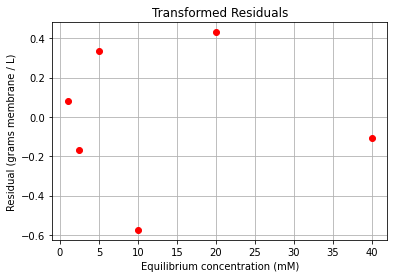

In [8]:
# Plot linearized isotherm versus data
# The last argument toggles between the two transformations we'll consider
plot_liniso(x,y,slope,intercept,'lin1')

**Interpretation (Regression Plot)**: We see an excellent fit with the transformed data. Or so it seems...


**Interpretation (Transformed Residuals)**: We start with a disclaimer; it is very difficult to interpret residuals for 6 data points. Recall, our regression analysis assumes the experimental observation errors are normally distributed. It is nearly impossible to determine if 6 points are normally distributed.

Instead, we will focus on checking for any problematic trends in the residuals. We see:
* The residuals are heteroskedastic, i.e., their variance is not constant. Notice the residuals near $c=0$ and $c=40$ are small, but the residuals between $5 \leq c \leq 20$ are large.
* There is only one data point at the extreme value $x=40$. This means the data point has **high leverage** and influences the best fit. Large errors for this experiment can greatly influence fitted parameters.

The plot above uses the transformed variables. They were computed with the transformed variables `x` and `y`.


Next, we will define the second function which **plots the fitted Langmuir isotherm** without transformation and **plots the non-transformed residuals**. Notice the function can be directly reused for each regression strategy.

In [9]:
# define a function to plot Langmuir isotherm
def plot_langiso(c,q,K,Q,title):
    ''' 
    function to plot fitted Langmuir isotherm and data
    Arguments:
        c: independent variable i.e. concentration - experimental data [mM] (float vector)
        q: membrane loading - experimental data [l/gram membrane] (float vector)
        K: fitted parameter [1/mmol] (float scalar)
        Q: fitted parameter [mol/gram membrane] (float scalar)
        title: name of regression to add to title (string)
    Returns:
        nothing
    '''
    
    ## evaluate the model
    # determine maximum value of c
    cmax = np.amax(c);
    # define range of x to evaluate the model
    c_span = np.linspace(0,1.2*cmax,50);
    # evaluate the model
    q_hat = Q*K*c_span / (1 + K*c_span)
    
    # plot the best fit model
    plt.figure()
    plt.title('Langmuir Isotherm')
    plt.plot(c_span,q_hat,'b-',label="Fitted Model")
    plt.plot(c,q,'r.',label="Experimental Data")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Concentration (mM)")
    plt.ylabel("Loading (mmol / grams membrane)")
    plt.show()
    
    ## calculate the residuals
    r = q - Q*K*c/(1+K*c)
    
    ## plot the residuals
    plt.figure()
    plt.plot(c,r,'ro')
    plt.ylabel('Residual (mmol / grams membrane)')
    plt.xlabel('Equilibrium concentration (mM)')
    plt.grid(True)
    plt.title('Residuals from {0} regression'.format(title))
    plt.show()
    
# End: define a function to plot Langmuir isotherm

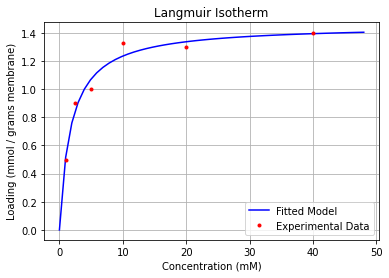

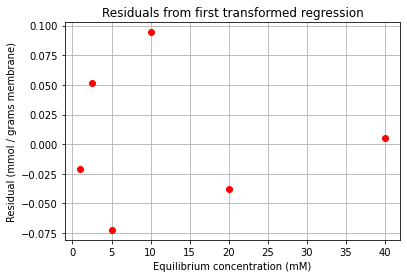

In [10]:
# Plot Langmuir isotherm
plot_langiso(c,q,Klin1,Qlin1,'first transformed')

**Interpretation (Regression Plot)**: By plotting in the original variables, we see the fit is not great. There is a significant residual for the $c=10$ mM experiment.

**Interpretation (Residuals)**: This residual plot has a very similar pattern to the transformed residual plot. (Notice the vertical axis is different). The interpreation from above also applies to this plot.

#### Step iii: Compute Covariance Matricies

Next, we will compute the **covariance matrix for the fitted parameters $\beta_0$ and $\beta_1$**.

We will start by computing the variance of the residuals. Recall the formula is:

$$\hat{\sigma}_r = \frac{1}{n-p} \sum_{i=1}^{n} (r_i - 0)^2$$

Here $n$ is the number of observations, $p$ is the number of fitted parameters, and $r_i$ is the residual for observation $i$. An interesting property of linear regression is that the mean of the residuals is always zero.

We can write the above formula with linear algebra in one line of code:

In [11]:
# compute the residuals (using the transformed variables)
r = y - (x*slope + intercept);

# variance of residuals
var_r = r @ r / (n-p)
print("Variance of residuals =",var_r," (g / L)^2")

Variance of residuals = 0.16885199230665526  (g / L)^2


Recall from the previous class, `stats.linregress` does not directly compute the covariance of the linear regression parameters. Instead, we need to write the regression problem in matrix notation:

$$
\underbrace{\vec{y}}_{\mathbb{R}^{n x 1}} = \underbrace{\mathbf{X}}_{\mathbb{R}^{n x m}} \cdot \underbrace{\vec{\beta}}_{\mathbb{R}^{m x 1}} + \underbrace{\vec{\epsilon}}_{\mathbb{R}^{n x 1}}
$$

Observations: $\vec{y} = [y_1, y_2, ..., y_n]^T$

Fitted Parameters: $\vec{\beta} = [\beta_0, \beta_1, ..., \beta_{m}]^T$

Data / Feature Matrix:

$$
\mathbf{X} = \begin{bmatrix} 1 & x_{1,1} & x_{1,2} & \dots & x_{1,m} \\
1 & x_{2,1} & x_{2,2} & \dots & x_{2,m} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{n,1} & x_{n,2} & \dots & x_{n,m}
\end{bmatrix}
$$

For our transformed membrane, the feature matrix is:

$$
\mathbf{X} = \begin{bmatrix} 1 & c_1 \\
1 & c_{2} \\
\vdots & \vdots \\
1 & c_{n}
\end{bmatrix}
$$

In [12]:
# feature matrix, a.k.a. data matrix, a.k.a. predictor matrix
X = np.ones((n,2))
X[:,1] = c
print("X=\n",X)

X=
 [[ 1.   1. ]
 [ 1.   2.5]
 [ 1.   5. ]
 [ 1.  10. ]
 [ 1.  20. ]
 [ 1.  40. ]]


Next, we will compute the **covariance matrix of the fitted parameters**:

$$\Sigma_{\hat{\beta}} = \hat{\sigma}_r^2  (\mathbf{X}^T \mathbf{X})^{-1}$$

In [13]:
# assemble covariance matrix for regression parameters
cov_b = var_r * np.linalg.inv(X.transpose() @ X)

Finally, we will propogate the covariance matrix of the transformed fitted parameters, $\mathbf{\Sigma_{\vec{\beta}}}$, to determine the **covariance matrix of the desired isotherm parameters**, $\mathbf{\Sigma_{\vec{\theta}}}$.

Recall of model transformation:

$$K = \frac{\beta_1}{\beta_0}, \qquad Q = \frac{1}{\beta_1}, $$

We will define the vector of model parameters as $\vec{\theta} = [K, Q]^T$.

In anticipation of applying the general nonlinear error propagation formula, we will calculate the following **partial derivatives**:

$$
\frac{\partial K}{\partial \beta_0} = -\frac{\beta_0}{\beta_1^2}, \qquad \frac{\partial K}{\partial \beta_1} = \frac{1}{\beta_0}
$$

$$
\frac{\partial Q}{\partial \beta_0} = 0, \qquad \frac{\partial Q}{\partial \beta_1} = -\frac{1}{\beta_1^2}
$$

We can then assemble these gradients into the Jacobian matrix:

$$
\mathbf{\nabla_{\vec{\beta}} \vec{\theta}} = \begin{bmatrix}
\frac{\partial K}{\partial \beta_0} & \frac{\partial K}{\partial \beta_1} \\
\frac{\partial Q}{\partial \beta_0} & \frac{\partial Q}{\partial \beta_1}
\end{bmatrix}
$$


In [14]:
# Assemble gradient vectors for K and Q
gradK = np.array([-slope / intercept**2, 1/intercept])
gradQ = np.array([0, -1/slope**2])

print("\nGradient of K:",gradK)
print("Gradient of Q:",gradQ)

# Assemble gradient vector
jac = np.stack((gradK, gradQ));
print("\nJacobian Matrix:\n",jac)


Gradient of K: [-0.45190522  0.8115721 ]
Gradient of Q: [ 0.         -2.12428953]

Jacobian Matrix:
 [[-0.45190522  0.8115721 ]
 [ 0.         -2.12428953]]


For this problem, calculating the partial derivates was very straightforward; but for more complex expression, we can use a finite difference approximation. We'll see this later in the case study.

We can now apply the **general nonlinear error propagation formula**:

$$
    \Sigma_{\hat{\theta}} \approx \left( \mathbf{\nabla_{\vec{\beta}} \vec{\theta}} \right) \left(\Sigma_{\hat{\beta}} \right) \left(\mathbf{\nabla_{\vec{\beta}} \vec{\theta}}\right)^T$$


In [15]:
# Apply nonlinear error propagation formula
cov_theta_lin1 = jac @ cov_b @ jac.transpose()

print("\nCovariance of Original Model Parameters (K,Q):\n",cov_theta_lin1)


Covariance of Original Model Parameters (K,Q):
 [[ 0.01265455 -0.00218224]
 [-0.00218224  0.00068943]]


<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Write down at least three questions or observations you have about the code for the first transformated regression model (all of Section 1A). We will start class by answering your questions.
</div>

**Your Questions:**

1.

2.

3.

### B. Paramter estimation using an alternate transformation and linear regression

#### Step i: Setup and Best Fit

We start with the Languir isotherm:

$$ q = \frac{Q \cdot K \cdot c}{1 + K \cdot c}$$

With a little bit of algebra, we obtain:

$$ \frac{1}{q} =  \frac{1}{Q} + \frac{1}{Q \cdot K} \cdot \frac{1}{c} $$

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Identify $x$, $y$, $\beta_0$, and $\beta_1$ in the alternate transformed model.
</div>

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Use `stats.linregress` to compute the best fit line. To maximize code reuse, save the results in variables <tt>slope</tt> and <tt>intercept</tt>.
</div>

In [16]:
### BEGIN SOLUTION
x = 1/c;
y = 1/q;

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope =",slope)
print("intercept =",intercept)
### END SOLUTION

slope = 1.3058364578345456
intercept = 0.6714412635365661


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Determine the new formulas to compute $K$ and $Q$ from the new fitted parameters $\beta_0$ and $\beta_1$. We recommend writing this on paper first. To typeset your answer below, just double click on the markdown cell and edit the formula. You do not need to turn in your on paper work.
</div>

$$K = \frac{?}{?}, \qquad Q = \frac{?}{?}, $$

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Compute $K$ and $Q$ from new model. Store your answers in the variances <tt>Klin2</tt> and <tt>Qlin2</tt>.
</div>

In [17]:
## Reverse transformation to obtain Q and K and display results
### BEGIN SOLUTION
Klin2 = intercept/slope;
Qlin2 = 1/intercept;
### END SOLUTION
print("\nK (alternate linear regression) = {0:0.1f} L/mmol".format(Klin2));
print("Q (alternate linear regression) = {0:0.1f} mmol/g_membrane".format(Qlin2));


K (alternate linear regression) = 0.5 L/mmol
Q (alternate linear regression) = 1.5 mmol/g_membrane


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Plot the transformed model and the transformed residuals. Hint: When using the <tt>plot_liniso</tt> function, enter <tt>'lin2'</tt> as the fourth argument. This will add the appropraite units to the plot.
</div>

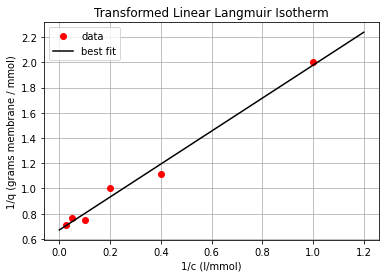

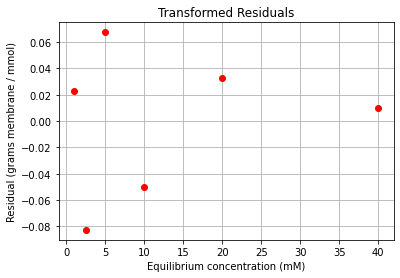

In [18]:
### BEGIN SOLUTION
plot_liniso(x,y,slope,intercept,'lin2')
### END SOLUTION

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Interpret the plot. Write 3 bullet points (sentences) with your observations.
</div>

**Your Observations:**

1.

2.

3.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Plot the Langmuir isotherm model and the (non-transformed) residuals. Hint: When using the <tt>plot_langiso</tt> function, enter <tt>'first transformed'</tt> as the fifth argument. This will add the appropraite title to the plot. Also remember to use <tt>Klin2</tt> and <tt>Qlin2</tt>.
</div>

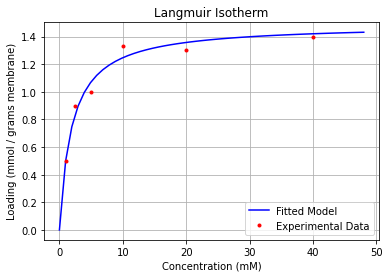

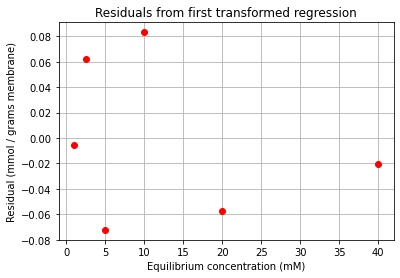

In [20]:
# Plot Langmuir isotherm
### BEGIN SOLUTION
plot_langiso(c,q,Klin2,Qlin2,'first transformed')
### END SOLUTION

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Interpret these plots. Write 3 bullet points (sentences) with your observations.
</div>

**Your Observations:**

1.

2.

3.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Calculate the residuals and store in variable <tt>r2</tt>.
</div>

In [29]:
# Calculate residuals
### BEGIN SOLUTION
r2 = y - (x*slope + intercept);
### END SOLUTION

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Calculate the variance of the residuals. Store in variable <tt>var_r2</tt>.
</div>

In [30]:
# variance of residuals
### BEGIN SOLUTION
var_r2 = r2 @ r2 / (n-p)
### END SOLUTION

print("Variance of residuals =",var_r2," (g / mmol)^2")

Variance of residuals = 0.0038915047452551866  (g / mmol)^2


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Assemble the feature matrix and store in variable <tt>X2</tt>.
</div>

In [31]:
# matrix of predictors
### BEGIN SOLUTION
X2 = np.ones((n,2))
X2[:,1] = 1/c
### END SOLUTION

print("X2 =\n",X2)

X2 =
 [[1.    1.   ]
 [1.    0.4  ]
 [1.    0.2  ]
 [1.    0.1  ]
 [1.    0.05 ]
 [1.    0.025]]


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Calculate the covariance of the linear regression parameters. Store the result in <tt>cov_b2</tt>.
</div>

In [32]:
# assemble covariance matrix for regression parameters
### BEGIN SOLUTION
cov_b2 = var_r2 * np.linalg.inv(X2.transpose() @ X2)
### END SOLUTION

print("Covariance of Transformed (Linearized) Regression Parameters (1/KQ, 1/Q):\n",cov_b2)

Covariance of Transformed (Linearized) Regression Parameters (1/KQ, 1/Q):
 [[ 0.00114359 -0.00167326]
 [-0.00167326  0.00565609]]


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Study the code below for the gradients of $K$ and $Q$ with respect to the new $\beta_0$ and $\beta_1$. Do you agree with this calculation? Did we make a mistake?
</div>

In [33]:
gradK2 = np.array([1/slope, -intercept/slope**2])
gradQ2 = np.array([-1/intercept**2, 0])

print("\nGradient of K:",gradK2)
print("Gradient of Q:",gradQ2)


Gradient of K: [ 0.76579268 -0.39375896]
Gradient of Q: [-2.21811442  0.        ]


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Assemble the gradients into the Jacobian matrix. Store the matrix in <tt>jac2</tt>.
</div>

In [34]:
### BEGIN SOLUTION
jac2 = np.stack((gradK2, gradQ2));
### END SOLUTION

print("\nJacobian Matrix:\n",jac2)


Jacobian Matrix:
 [[ 0.76579268 -0.39375896]
 [-2.21811442  0.        ]]


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Apply the multivariate general nonlinear error propagation formulation. Store the covariance matrix of the original model parameters in <tt>cov_theta_lin2</tt>.
</div>

In [35]:
# Apply nonlinear error propagation formula
### BEGIN SOLUTION
cov_theta_lin2 = jac2@ cov_b2 @ jac2.transpose()
### END SOLUTION

print("\nCovariance of Original Model Parameters (K,Q):\n",cov_theta_lin2)


Covariance of Original Model Parameters (K,Q):
 [[ 0.0025567  -0.00340395]
 [-0.00340395  0.0056265 ]]


### C. Paramter estimation using nonlinear regression

We will now apply nonlinear regression to our problem. First, we need to define a function to evaluate the model.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Fill in the missing line in <tt>model_func</tt> below.
</div>

In [36]:
## Code for parameter estimation using nonlinear regression

# define function for the model being fitted
def model_func(theta, c):
    '''
    Function to define model being fitted
    Arguments:
        theta: parameter vector (K, Q)
        c: concentration(s) to evaluate (scalar or vector)
    Returns:
        qhat: predicted loading(s), (scalar or vector)
    '''
    ### BEGIN SOLUTION
    qhat = (theta[0]*theta[1]*c) / (1 + theta[0]*c)
    ### END SOLUTION
    return qhat
# End: define function for the model being fitted

Next we need to define a function to calculate the residuals for each data point.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Fill in the missing line in <tt>regression_func</tt> below.
</div>

In [37]:
# define function to return residuals of model being fitted
def regression_func(theta, c, q):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        theta: parameter vector
        c: concentration(s) to evaluate (vector)
        q: loading(s) to fit (vector)
    Returns:
        ls_func: evaluation of loss function
    '''
    qhat = model_func(theta,c)

    ### BEGIN SOLUTION
    r = q-qhat
    ### END SOLUTION
    return r
# End: define function to return residuals of model being fitted

Now we perform nonlinear regression.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Use the function <tt>optimize.least_squares</tt> to compute the best fit. Store the results in the variable <tt>theta_fit</tt>.
</div>

In [38]:
# Perform nonlinear parameter estimation

# initial guess
theta_guess = np.array([1, 1])

# nonlinear regression
### BEGIN SOLUTION
theta_fit = optimize.least_squares(regression_func, theta_guess,method='lm',args=(c, q),verbose=2)
### END SOLUTION

# Extract fitted parameters and display results
Knl = theta_fit.x[0]
Qnl = theta_fit.x[1]
print("\nK (nonlinear regression) = {0:0.1f} l/mmol".format(Knl));
print("Q (nonlinear regression) = {0:0.1f} mmol/g_membrane".format(Qnl));

`ftol` termination condition is satisfied.
Function evaluations 20, initial cost 2.7019e-01, final cost 9.2968e-03, first-order optimality 1.11e-08.

K (nonlinear regression) = 0.6 l/mmol
Q (nonlinear regression) = 1.5 mmol/g_membrane


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Plot the fitted model and residuals. Hint: Use the function <tt>plot_langiso</tt>. Enter <tt>'nonlinear'</tt> as the fifth argument.
</div>

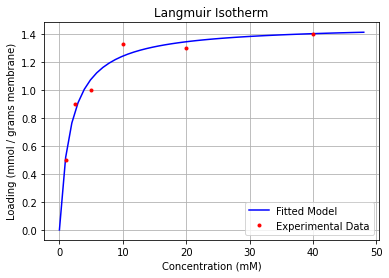

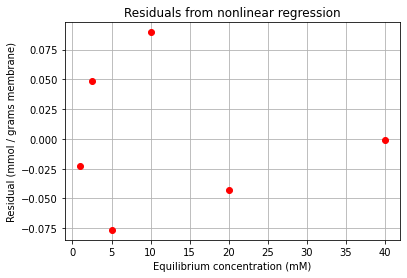

In [39]:
### BEGIN SOLUTION
plot_langiso(c,q,Knl,Qnl,'nonlinear')
### END SOLUTION

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Interpret these plots. Write 3 bullet points (sentences) with your observations.
</div>

**Your Observations:**

1.

2.

3.

We will complete the nonlinear regression analysis by estimating the covariance of the fitted parameters $\mathbf{\Sigma}_{\vec{\theta}}$.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Calculate the residuals and store in <tt>r3</tt>. Next calculate the variance of the residuals and store in <tt>var_r3</tt>.
</div>

In [41]:
# Calculate residuals. Hint: use model_func
### BEGIN SOLUTON
# calculate residuals
r3= q - model_func(theta_fit.x, c)
### END SOLUTION

# Calculate the variance of the residuals
### BEGIN SOLUTION
var_r3 = r3 @ r3 / (n-p)
### END SOLUTION

print("Variance of the residuals: ",var_r3,"(mmol/g)^2")

Variance of the residuals:  0.004648376875480317 (mmol/g)^2


Recall from the previous class the covariance matrix for nonlinear regression has a similar formula to the linear regression case:

$$\mathbf{\Sigma_{\vec{\theta}}} \approx \hat{\sigma}_r^2 (\mathbf{J}^T \mathbf{J})^{-1}$$

where $\mathbf{J}$ is the Jacobian of the residuals w.r.t. $\vec{\theta}$:

$$
J_{i,j} = \frac{\partial(y_i - \hat{y}_i)}{\partial \theta_j}
$$

This IS NOT the same Jacobian matrix for nonlinear error propagation. Does this formula look familar? Recall, for LINEAR REGRESSION, the covariance estimate is:

$$\Sigma_{\hat{\beta}} = \hat{\sigma}_r^2  (\mathbf{X}^T \mathbf{X})^{-1}$$

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Compare the nonlinear regression and linear regression covariance formulas. Compute the elements of the Jacobian matrix for a linear model using $\vec{\theta} = \vec{\beta}$. How are $\mathbf{J}$ and $\mathbf{X}$ related? Discuss then write one sentence.
</div>

**Discussion**:

Luckily, `optimize.least_squares` computes this Jacobian for us automatically.

In [42]:
print("J =\n",theta_fit.jac)

J =
 [[-0.60433286 -0.3573991 ]
 [-0.6402919  -0.5816669 ]
 [-0.51189153 -0.73551125]
 [-0.33990149 -0.84760183]
 [-0.19914358 -0.91751568]
 [-0.10832244 -0.95698376]]


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Compute the covariance matrix $\mathbf{\Sigma_{\vec{\theta}}}$. Store your answer in <tt>cov_theta_nl</tt>.
</div>

In [43]:
# assemble covariance matrix
### BEGIN SOLUTION
cov_theta_nl = var_r3*np.linalg.inv(theta_fit.jac.T @ theta_fit.jac)
### END SOLUTION
# plot Langmuir isotherm
print("Covariance Matrix of Original Model Parameters (K,Q):\n",cov_theta_nl)

Covariance Matrix of Original Model Parameters (K,Q):
 [[ 0.00887448 -0.00392218]
 [-0.00392218  0.00306799]]


### D. Comparison of Three Regression Approaches

**First Transformation + Linear Regression**

In [44]:
print("\nK (linear regression) = {0:0.3f} l/mmol".format(Klin1));
print("Q (linear regression) = {0:0.3f} mmol/g_membrane".format(Qlin1));

print("\nCovariance of Original Model Parameters (K,Q):\n",cov_theta_lin1)


K (linear regression) = 0.557 l/mmol
Q (linear regression) = 1.457 mmol/g_membrane

Covariance of Original Model Parameters (K,Q):
 [[ 0.01265455 -0.00218224]
 [-0.00218224  0.00068943]]


**Second (Alternative) Transformation + Linear Regression**

In [45]:
print("\nK (alternate linear regression) = {0:0.3f} L/mmol".format(Klin1));
print("Q (alternate linear regression) = {0:0.3f} mmol/g_membrane".format(Qlin2));


print("\nCovariance of Original Model Parameters (K,Q):\n",cov_theta_lin2)


K (alternate linear regression) = 0.557 L/mmol
Q (alternate linear regression) = 1.489 mmol/g_membrane

Covariance of Original Model Parameters (K,Q):
 [[ 0.0025567  -0.00340395]
 [-0.00340395  0.0056265 ]]


**Nonlinear Regression**

In [46]:
print("\nK (nonlinear regression) = {0:0.3f} l/mmol".format(Knl));
print("Q (nonlinear regression) = {0:0.3f} mmol/g_membrane".format(Qnl));

print("\nCovariance Matrix of Original Model Parameters (K,Q):\n",cov_theta_nl)


K (nonlinear regression) = 0.556 l/mmol
Q (nonlinear regression) = 1.464 mmol/g_membrane

Covariance Matrix of Original Model Parameters (K,Q):
 [[ 0.00887448 -0.00392218]
 [-0.00392218  0.00306799]]


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discussion the following question. Write a one sentence answer for each question.
</div>

**Disucssion**:
1. *How many significant figures are we estimating for $Q$ and $K$ based on the original data?* **Answer:** Fill in here...
2. *Do the three regression strategies give the same or different estimates for $K$ (within reasonable significant figures)?* **Answer:** Fill in here...
3. *Do the three regression strategies give the same or different estimates for $Q$ (within reasonable significant figures)?* **Answer:** Fill in here...
4. *Do the three regression strategies give the same estimate for uncertainty (covariance)?*
5. *Which regression technique is best suited for this problem?* **Answer:** Fill in here...

## 2. Estimate Batch Processing Time with Numeric Integration

Our ultimate goal is to design a point-of-use semi-batch adsorptive membrane system to remove Pb from water. Water with contaminant concentration $c_{in} =$ 150 parts per billion (ppb) enters the system. Some of the contaminant adsorbs such that the outlet concentration, $c(t)$, is in equilibrium and can be related to the sorbent loading, $q(t)$, using the Langmuir isotherm $q=f(K,Q)$. Using a differential mass balance (you will learn more about this in Transport I and II as Juniors), one can derive:

$$
\frac{d}{dt} q(t) = \frac{F}{m}(c_{in} - c(t))
$$

where $m = $ 1 kg is the total mass of the membrane and $F = $ 2 ml/s is the flow rate of water. We will operate the membrane until time $t_f$ where $c(t_f) = c_{max} = $ 15 ppb, which corresponds to maximum contaminant limit from the US EPA. At time $t_f$ the membrane is regenerated (e.g., washed with a low pH solution to remove the Pb contaminant) and the operating cycle repeats. For simplicity, we will assume the membrane is completely regenerated such that $q(0) = 0$.

### A. Model Manipulation and Setup

We want to integrate the differential equation above to find the final time $t_f$ where $c(t_f) = c_{max} = $ 15 ppb. This is a boundry value problem. We have three choices for a solution approach:
1. Analytically integrate the differential equation. (You can do this with Wolframa Alpha, but the answer is complicated.)
2. Numerically integrate the differential equation with `solve_ivp`. Then use interpolation or Newton's method to find the value of $t_f$ that satisfies the boundary condition.
3. Rearrange the model then integrate with a quadrature rule.

Let's use option 3.

We will first start with the Langmuir isotherm:

$$
q(t) = \frac{K \cdot Q \cdot c(t)}{1 + K \cdot c(t)}
$$

We can rerange the isotherm to obtain:
$$
c(t) = \frac{q(t)}{Q \cdot K - q(t) \cdot K}
$$

We will then substitute the expression for $c(t)$ into the differential equation to obtain:

$$
\frac{d}{dt} q(t) = \frac{F}{m} \left( c_{in} - \frac{q(t)}{Q \cdot K - q(t) \cdot K} \right)
$$

For solution approach 2, we can numerically integrate this differential equation. But for solution approach 3, we will rearrange the equation as follows:

$$
dt = \frac{m}{F} \frac{1}{\left( c_{in} - \frac{q(t)}{Q \cdot K - q(t) \cdot K} \right)} dq(t)
$$

Integrating both sides of the equation gives:

$$
\int_{t_0}^{t_f} dt = \int_{q_0}^{q_f}  \frac{m}{F} \frac{1}{\left( c_{in} - \frac{q(t)}{Q \cdot K - q(t) \cdot K} \right)} dq(t)
$$

By assuming $t_0=0$, we get:

$$
t_f = \int_{q_0}^{q_f}  \frac{m}{F} \frac{1}{\left( c_{in} - \frac{q(t)}{Q \cdot K - q(t) \cdot K} \right)} dq(t)
$$

Because $\frac{m}{F}$ is a constant, we can move it out of the integral:

$$
t_f = \frac{m}{F}  \int_{q_0}^{q_f} \frac{1}{\left( c_{in} - \frac{q(t)}{Q \cdot K - q(t) \cdot K} \right)} dq(t)
$$

We can approximate this integral with a quadrature rule.

### B. Numeric Integration

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Complete the function below to estimate $t_f$.
</div>

In [47]:
# Code for numerical integration and calculation of tf

# Define a function to numerically integrate the differential mass balance to give tf
def calculate_tf(theta,LOUD=False):
    ''' 
    Calculate the elapsed time (tf) in seconds before the bed needs to be regenerated
    Arguments:
        theta: vector of model parameters where K(l/mmol) = theta[0] and Q (mmol/g_membrane) = theta[1] (floats)
        LOUD: toggle on/off print statement
    Returns:
        tf (hours) : time at which the membrane needs to be regenerated (float)
    '''
    
    K = theta[0]
    Q = theta[1]
    
    cin_ppb = 150 # ppb
    clim_ppb = 15 # ppb
    
    F = 2*1e-3; # [L/s]
    
    # Convert cin and clim to mM units, to make it consistent with our model
    # ppb = 1mg/m3 = (1x10^-3/207.2) mol / (1000 l) = (1/207.2) x 10^-3 mM

    cin = (cin_ppb/207.2)*1e-3 # mM
    clim = (clim_ppb/207.2)*1e-3 # mM
    
    q0 = 0 # [mmol/g-membrane]
    
    m = 1000 # g-membrane
    
    # define a lambda function for the Langmuir isotherm
    # save the function in the variable 'calc_q'
    ### BEGIN SOLUTION
    calc_q = lambda c : Q*K*c / (1 +  K*c)
    ### END SOLUTION
        
    ## Step 1: Calculate qf using isotherm
    qf = calc_q(clim)
    if LOUD:
        print("qf =",qf,"mmol/g")
    
    ## Step 2: Apply quadrature rule to integrate dq
    #
    # Define a lambda function for the integrand
    # Then use 'integrate.quad'
    # Finally, calculate 'tf'
    ### BEGIN SOLUTION
    dq = lambda q: 1 / (cin - q / (Q*K - q*K))
    val, tol = integrate.quad( dq, q0, qf)
    tf = m/F * val
    ### END SOLUTION
    
    # Convert from seconds to hours
    return tf / 3600
# End: Define a function to numerically integrate the differential mass balance to give tf

We will now test our function:

In [48]:
# Unit Test:
Qtest = 1.5 # mmol/g_membrane
Ktest = 0.6 # L/mmol

print("Unit Test:")
print("K =",Ktest,"L/mmol")
print("Q =",Qtest,"mmol/g_membrane")
tf_test = calculate_tf([Ktest,Qtest],LOUD=True)
print("tf = {0:0.2f} hours".format(tf_test));

Unit Test:
K = 0.6 L/mmol
Q = 1.5 mmol/g_membrane
qf = 6.515161020998122e-05 mmol/g
tf = 13.17 hours


Success. We have calculated the regeneration time of the membrane system.

## 3. Uncertainty Propagation (Nonlinear Formula)

We now want to propogate the covariance of our fitted parameters $\mathbf{\Sigma_{\vec{\theta}}}$ to estimate the uncertainty in the calculated batch time $\sigma_{t_f}$. To do this, we will apply the general nonlinear error propagation formula:

$$ \sigma_{t_f} \approx \left( \nabla_{\vec{\theta}} t_f \right) \left(\mathbf{\Sigma_{\vec{\theta}}} \right) \left( \nabla_{\vec{\theta}} t_f \right)^{T}
$$

This requires us to compute (or estimate!) the gradient vector:

$$
\nabla_{\vec{\theta}} t_f = \begin{bmatrix} \frac{\partial t_f}{\partial K},~ \frac{\partial t_f}{\partial Q} \end{bmatrix}
$$

Note: During some class notes we define the gradiant vector with a transpose, which requires the transpose to move in the error propagation formula. Either way is common in textbooks. Our apologies for the inconsistency and any confusion. Here is a good rule: just make sure the matrix dimensions work for multiplication and add a transpose if needed!


### A. Define Functions

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Complete the function below to estimate $uc_tf$.
</div>

In [49]:
# define a function to perform nonlinear error propagation
def nonlinear_error_propagation(theta,cov_theta,LOUD=True):
    '''
    Function to perform nonlinear error propagation through regeneration time calculations
    using forward finite difference gradient
    
    Arguments:
        theta: vector of model parameters where K(l/mmol) = theta[0] 
        and Q (mmol/g_membrane) = theta[1] (vector floats)
        cov_theta: covariance matrix of theta (matrix of floats)
        LOUD: toggle on/off printing
    Returns:
        uc_tf (hours) : uncertainty (standard deviation) in time at which the membrane needs to be regenerated
    '''

    ## Step 1. Calculate gradient of tf calculate to Q and K
    # We will use finite difference!

    tf_ref = calculate_tf(theta)
    n = len(theta)
    
    theta_copy = theta.copy()
    
    grad = np.zeros(n)
    
    eps = 1E-6
    
    # Instructions: fill in the three missing lines below.
    for i in range(n):
        
        # perturb
        ### BEGIN SOLUTION
        theta_copy[i] += eps
        ### END SOLUTION
        
        # forward finite difference
        ### BEGIN SOLUTION
        grad[i] = (calculate_tf(theta_copy) - tf_ref) / eps
        ### END SOLUTION
        
        # reset
        ### BEGIN SOLUTION
        theta_copy[i] = theta[i]
        ### END SOLUTION
        
    if LOUD:
        print('grad=',grad)
        
    ## Step 2. Apply nonlinear error propagation formula
    # Instructions: fill in the missing line
    # store the result in the variable 'var_tf'
    # Hint: Numpy is smart enough to know that 'grad' is a vector. It will add a transpose as
    # need to matrix the matrix dimensions.
    ### BEGIN SOLUTION
    var_tf = grad @ cov_theta @ grad
    ### END SOLUTION
    
    ## Step 3. Calculate standard deviation
    uc_tf = np.sqrt(var_tf)
    
    
    print("\nUncertainty (standard deviation) of tf: {0:0.2f} hours".format(uc_tf))
    
    return uc_tf
# end: define a function to perform nonlinear error propagation

Let's test our function with the results for the first transformed model.

In [50]:
sigma_tf_test = nonlinear_error_propagation([Klin1, Qlin1], cov_theta_lin1)

grad= [21.32635417  8.14794015]

Uncertainty (standard deviation) of tf: 2.25 hours


Great, our function works. We can also calculate a 95% confidence interval for the estimated batch time.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss the code below with a partner. Then write a comment to explain the calculation.
</div>

In [51]:
# define a function to print the 95% confidence interval
def conf_int(t, t_uc, dof):
    '''
    function to calculate, print and return the 95% confidence interval for 
    tf
    
    args
    t (s): regeneration time for the membrane (float)
    t_uc (s) : uncertainty (standard deviation) in t (float)
    dof (-) : degrees of freedom in the system (int)
    
    returns
    t_cint (s) : 95% confidence interval for t (float vector)
    '''
    
    ## Add a comment here to explain this line
    t_cint = t + t_uc*stats.t.ppf([.025, .975], dof)

    print("\n95% confidence interval for tf: [{0:0.2f} hr, {1:0.2f} hr]".format(t_cint[0],t_cint[1]));
    
    return t_cint;

Let's test our function with the results for the first transformed model.

In [52]:
cint_tf_test = conf_int(tf_test, sigma_tf_test, n-p)


95% confidence interval for tf: [6.93 hr, 19.40 hr]


Note we used `tf_test` for this unit test which does not correspond to our regression results. Do not attempt to interpret the above results.

Now we can apply these two functions to our three regression strategies.

### B. First Transformation + Linear Regression

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Calculate the uncertainty in the $t_f$ predictions and a 95% confidence interval.
</div>

In [53]:
### BEGIN SOLUTION
# Calculate tf using parameters from linear regression

tf_lin1 = calculate_tf([Klin1, Qlin1]);

# Code for uncertainty propagation with linear regression
sigma_tf_lin1 = nonlinear_error_propagation([Klin1, Qlin1], cov_theta_lin1)


# 95% confidence interval for linear regression
cint_tf_lin1 = conf_int(tf_lin1, sigma_tf_lin1, n-p)
### END SOLUTION

grad= [21.32635417  8.14794015]

Uncertainty (standard deviation) of tf: 2.25 hours

95% confidence interval for tf: [5.64 hr, 18.11 hr]


### C. Second (Alternate) Transformation + Linear Regression

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Calculate the uncertainty in the $t_f$ predictions and a 95% confidence interval.
</div>

In [54]:
### BEGIN SOLUTION
# Calculate tf using parameters from linear regression

tf_lin2 = calculate_tf([Klin2, Qlin2]);

# Code for uncertainty propagation with linear regression
sigma_tf_lin2 = nonlinear_error_propagation([Klin2, Qlin2], cov_theta_lin2)

# 95% confidence interval for linear regression
cint_tf_lin2 = conf_int(tf_lin2, sigma_tf_lin2, n-p)
### END SOLUTION

grad= [21.79237003  7.52398947]

Uncertainty (standard deviation) of tf: 0.65 hours

95% confidence interval for tf: [9.41 hr, 13.00 hr]


### D. Nonlinear Regression

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Calculate the uncertainty in the $t_f$ predictions and a 95% confidence interval.
</div>

In [55]:
### BEGIN SOLUTION
# Calculate tf using parameters from nonlinear regression
tf_nl = calculate_tf([Knl, Qnl]);

# Code for uncertainty propagation with nonlinear regression
sigma_tf_nl = nonlinear_error_propagation([Knl, Qnl], cov_theta_nl)

# 95% confidence interval for nonlinear regression
cint_tf_nl = conf_int(tf_nl, sigma_tf_nl, n-p)
### END SOLUTION

grad= [21.41427393  8.13841288]

Uncertainty (standard deviation) of tf: 1.70 hours

95% confidence interval for tf: [7.18 hr, 16.64 hr]


### E. Discussion

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Compare the uncertainty estimates for batch time from the three regression approaches. Then write one sentence to answer each of the following questions.
</div>

**Disucssion**:
1. *Order the three regression estimates from smallest to largest uncertainty in batch time.* **Answer:** Fill in here...
2. *Which one regression result do you trust more than the other two?* **Answer:** Fill in here...
3. *Waiting too long to regenerate the membrane can result in accidental lead exposure. Based on our analysis, what is the maximum batch time you recommend before regenerating the membrane?* **Answer:** Fill in here...

## 4. Monte Carlo Uncertainty Propogation

We will revisit this notebook **during a future class this semester**.

To keep this example concise, we will only apply MC uncertainty propogation to the nonlinear regression method. We recommend nonlinear regression for most engineering examples.

### A. Inspect Residuals

We will start by characterizing the residuals for the nonlinear regression case. Let's start by plotting a histogram:

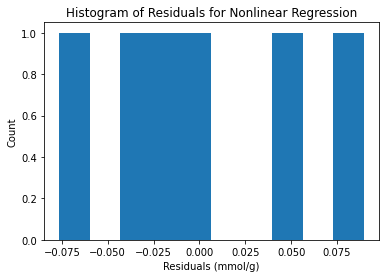

In [56]:
plt.hist(r3)
plt.xlabel("Residuals (mmol/g)")
plt.ylabel("Count")
plt.title("Histogram of Residuals for Nonlinear Regression")
plt.show()

Becase there are only 6 data points, this plot is not very revealing. We do not see any extreme outliers, which is pretty much all we can check. If we had more than 10 or 20 samples, we could expect the histogram of residuals to be approximately normally distributed.

Finally, recall that the variance of the residuals is stored in `var_r3`.

In [57]:
print("Variance of the residuals: ",var_r3,"(mmol/g)^2")

Variance of the residuals:  0.004648376875480317 (mmol/g)^2


### B. Monte Carlo Python Code

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Fill in the steps in the MC code below.
</div>

In [58]:
# Number of Monte Carlo samples
nmc = 1000; 

# Declare a matrix to save the Monte Carlo samples
# Rows: simulations
# Columns: fitted parameters
theta_mc = np.zeros((nmc,2))

# Declare a vector to save Monte Carlo sample
tf_mc = np.zeros(nmc)

# Estimate fitted paramters for the random samples
for i in range(nmc):
    
    # Add noise to the experimental data. Store the 'new' data in the vector 'noisy_data'
    ### BEGIN SOLUTION
    noise_vector = np.random.normal(loc = 0,scale = var_r3**0.5, \
                                    size=(n))
    noisy_data = q + noise_vector
    ### END SOLUTION
    
    ## Perform nonlinear regression
    ### BEGIN SOLUTION
    theta_init = [Knl, Qnl]
    sol = optimize.least_squares(regression_func,theta_init ,args=(c, noisy_data))
    ### END SOLUTION
    
    ## Store the results from regression
    ### BEGIN SOLUTION
    theta_mc[i,:] = sol.x
    ### END SOLUTION
    
    ## Calculate tf
    ### BEGIN SOLUTION
    tf_mc[i] = calculate_tf(sol.x)
    ### END SOLUTION
# end main MC loop

### C. Visualize and Interpret MC Results: Fitted Parameters

We will start by inspecting historgrams of the fitted parameters:

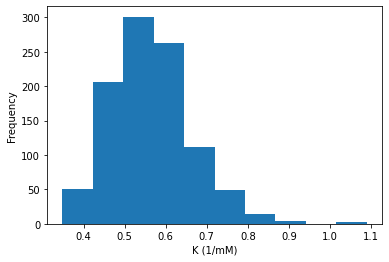

In [59]:
plt.hist(theta_mc[:,0])
plt.xlabel("K (1/mM)")
plt.ylabel("Frequency")
plt.show()

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Make a histogram for $Q$.
</div>

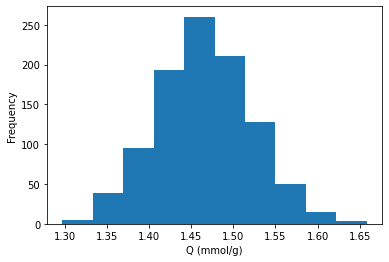

In [60]:
### BEGIN SOLUTION
plt.hist(theta_mc[:,1])
plt.xlabel("Q (mmol/g)")
plt.ylabel("Frequency")
plt.show()
### END SOLUTION

We can also make a scatter plot to see the relationship between uncertainty in $K$ and $Q$:

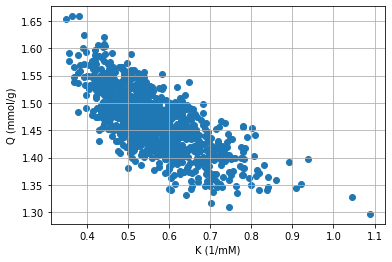

In [61]:
plt.scatter(theta_mc[:,0], theta_mc[:,1])
plt.xlabel("K (1/mM)")
plt.ylabel("Q (mmol/g)")
plt.grid(True)
plt.show()

We can also compute the covariance between $K$ and $Q$. We'll start by loading our MC results into a Pandas DataFrame:

In [62]:
mc = pd.DataFrame(theta_mc,columns={"K","Q"})
mc.head()

,Q,K
0,0.464379,1.558849
1,0.578028,1.467195
2,0.558018,1.482760
3,0.695723,1.401479
4,0.585941,1.466293


Then we can compute covariance and correlation:

In [63]:
mc.cov()

,Q,K
Q,0.009636,-0.004014
K,-0.004014,0.003165


In [64]:
mc.corr()

,Q,K
Q,1.000000,-0.726845
K,-0.726845,1.000000


Let's compare against our covariance matrix from Section 1C:

In [65]:
print("Covariance Matrix of Original Model Parameters (K,Q):\n",cov_theta_nl)

Covariance Matrix of Original Model Parameters (K,Q):
 [[ 0.00887448 -0.00392218]
 [-0.00392218  0.00306799]]


These results are similar! Why do we not expect them to match exactly?

### D. Visualize and Interpret MC Results: Batch Time

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Make a histogram for $t_f$.
</div>

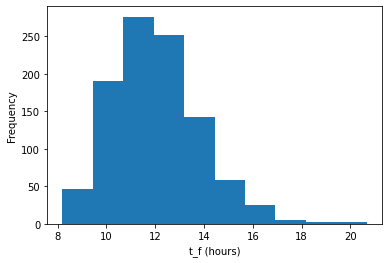

In [66]:
### BEGIN SOLUTION
plt.hist(tf_mc)
plt.xlabel("t_f (hours)")
plt.ylabel("Frequency")
plt.show()
### END SOLUTION

We can also calculate the mean and median batch time:

In [67]:
print("mean batch time =",np.mean(tf_mc)," hours")
print("median batch time =",np.median(tf_mc)," hours")

mean batch time = 12.034734451786232  hours
median batch time = 11.87109965875321  hours


As well as the standard deviation of batch time from the Monte Carlo simulations:

In [68]:
# Choose ddof=0 (default) versus ddof=1 with N=1000 do not matter that much
print("standard deviation of batch time =",np.std(tf_mc), "hours")

standard deviation of batch time = 1.767604761517864 hours


We can also calculate the 2.5%-ile and 97.5%-ile of batch time from the MC simulations.

In [69]:
print("2.5%-ile batch time =",np.percentile(tf_mc,2.5)," hours")
print("97.5%-ile batch time =",np.percentile(tf_mc,97.5)," hours")

2.5%-ile batch time = 9.123441347214365  hours
97.5%-ile batch time = 15.84766759583435  hours


Finally, let's compare the standard deviation and percentiles to $\sigma_{t_f}$ and the 95% confidence interval calculated in Section 3D (code copied for convienence):

In [70]:
# Calculate tf using parameters from nonlinear regression
tf_nl = calculate_tf([Knl, Qnl]);

# Code for uncertainty propagation with nonlinear regression
sigma_tf_nl = nonlinear_error_propagation([Knl, Qnl], cov_theta_nl)

# 95% confidence interval for nonlinear regression
cint_tf_nl = conf_int(tf_nl, sigma_tf_nl, n-p)

grad= [21.41427393  8.13841288]

Uncertainty (standard deviation) of tf: 1.70 hours

95% confidence interval for tf: [7.18 hr, 16.64 hr]


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Compare the uncertainty estimates in batch time and the standard deviation.
</div>